## Install Libraries


In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer
import itertools

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import and Visualise Datasets

In [6]:
df_inference = pd.read_json('/content/inference.jsonl', lines = True)
df_inference = df_inference.loc[:, ['text', 'label']].rename(columns={'text': 'text', 'label': 'target'})

In [7]:
df_train = pd.read_json('/content/drive/MyDrive/IR_Project/main_data_text/train.jsonl', lines = True)
df_train = df_train.loc[:, ['title', 'label']].rename(columns={'title': 'text', 'label': 'target'})

df_test = pd.read_json('/content/drive/MyDrive/IR_Project/main_data_text/test.jsonl', lines = True)
df_test = df_test.loc[:, ['title', 'label']].rename(columns={'title': 'text', 'label': 'target'})

df_val = pd.read_json('/content/drive/MyDrive/IR_Project/main_data_text/val.jsonl', lines = True)
df_val = df_val.loc[:, ['title', 'label']].rename(columns={'title': 'text', 'label': 'target'})




df_train.head()

,text,target
0,Depressed black man sitting outdoor. Stock Photo,1
1,Asian man feels sad on bed looking and focus o...,1
2,Portrait of happy excited positive cheerful te...,0
3,Unrecognizable young Asian man overwhelmed by ...,1
4,Child wearing red rain boots jumping into a pu...,0


In [8]:
np.random.seed(112)
print(len(df_train),len(df_val), len(df_test))

4380 547 548


<Axes: xlabel='target'>

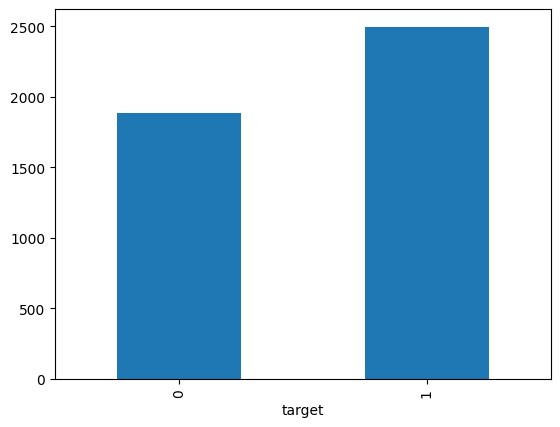

In [ ]:
df_train.groupby(['target']).size().plot.bar()

## Modelling

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [14]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = df['target'].to_list()
        self.texts = [tokenizer(str(text), 
                               padding='max_length', max_length = 64, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [11]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

## Training

In [ ]:
#training 

from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    # print("shape 1=", train_data.shape)
    # print("shape 2=", val_data.shape)
    
    train_loss_list = []  
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    train, val = Dataset(train_data), Dataset(val_data) 

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0
        total_acc_val = 0
        total_loss_val = 0

        num_batch_train = 0
        for train_input, train_label in tqdm(train_dataloader):
            
            num_batch_train += 1
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        
        train_loss_list.append(total_loss_train / num_batch_train)
        train_acc_list.append(total_acc_train / len(train_data))

        with torch.no_grad():
            num_batch_val = 0
            for val_input, val_label in val_dataloader:

                num_batch_val +=1
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())  
                total_loss_val += batch_loss.item()#  1 loss given per batch is summed
                
                # print(output.argmax(dim=1) == val_label)
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc  #1 acc  score of matching given per sample is summed
        
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / num_batch_train: .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / num_batch_val: .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}')
        # print(total_acc_val, len(val_data))
        
        val_loss_list.append(total_loss_val / num_batch_val)
        val_acc_list.append(total_acc_val / len(val_data))

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 274/274 [00:51<00:00,  5.35it/s]


Epochs: 1 | Train Loss:  1.330             | Train Accuracy:  0.482             | Val Loss:  0.855             | Val Accuracy:  0.797


100%|██████████| 274/274 [00:50<00:00,  5.47it/s]


Epochs: 2 | Train Loss:  0.584             | Train Accuracy:  0.906             | Val Loss:  0.402             | Val Accuracy:  0.952


100%|██████████| 274/274 [00:50<00:00,  5.47it/s]


Epochs: 3 | Train Loss:  0.284             | Train Accuracy:  0.965             | Val Loss:  0.198             | Val Accuracy:  0.974


100%|██████████| 274/274 [00:50<00:00,  5.45it/s]


Epochs: 4 | Train Loss:  0.159             | Train Accuracy:  0.978             | Val Loss:  0.140             | Val Accuracy:  0.976


100%|██████████| 274/274 [00:50<00:00,  5.48it/s]


Epochs: 5 | Train Loss:  0.109             | Train Accuracy:  0.985             | Val Loss:  0.111             | Val Accuracy:  0.982


In [ ]:
# free CUDA memory
torch.cuda.empty_cache()

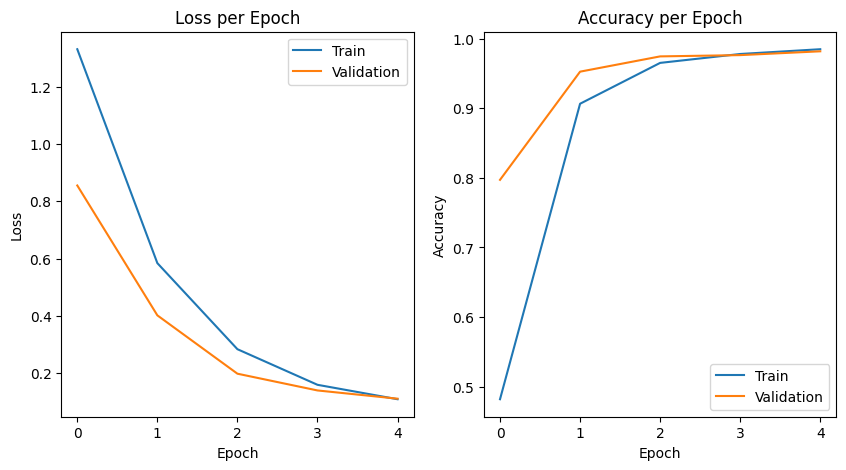

In [ ]:
# plot the training statistics
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train')
plt.plot(val_loss_list, label='Validation')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Validation')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
torch.save(model, '/content/drive/MyDrive/IR_Project/model_main_data.pth')

In [12]:
model = torch.load('/content/drive/MyDrive/IR_Project/model_main_data.pth')

## Testing

In [17]:
from sklearn.metrics import classification_report

def evaluate(model, test_data):

    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    predicted_labels = []
    actual_labels = []

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            _, predictions = torch.max(output, 1)

            # acc = (predictions == test_label).sum().item()
            # total_acc_test += acc

            predictions = np.array([tensor.cpu().numpy() for tensor in predictions])
            test_labels = np.array([tensor.cpu().numpy() for tensor in test_label])

            predicted_labels.append(list(predictions))
            actual_labels.append(list(test_labels))

            
        predicted_labels = list(itertools.chain(*predicted_labels))
        actual_labels = list(itertools.chain(*actual_labels))
        print(classification_report(predicted_labels, actual_labels))
    
    # print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return predicted_labels, actual_labels
    
predicted_labels, actual_labels = evaluate(model, df_test)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       238
           1       0.95      0.96      0.95       310

    accuracy                           0.95       548
   macro avg       0.95      0.95      0.95       548
weighted avg       0.95      0.95      0.95       548



## Inference

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def classify_text(text):
    # Tokenize the input text
    inputs = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt').to(device)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Perform the inference
    with torch.no_grad():
        output = model(input_ids, attention_mask)
        prediction = output.argmax(dim = 1)

    # # Convert the output to a Python scalar and return it
    # prediction = prediction.detach().cpu().numpy().item()
    return prediction

# Example usage
text = "life is beautiful i am very happy she is in love"
prediction = classify_text(text)
value = 'depressed' if prediction == 1 else 'not depressed'
print(f'Class Label =  {value}')

Class Label =  not depressed


### Inference for sample posts 

In [19]:
from sklearn.metrics import classification_report

def evaluate(model, test_data):

    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    predicted_labels = []
    actual_labels = []

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            _, predictions = torch.max(output, 1)

            # acc = (predictions == test_label).sum().item()
            # total_acc_test += acc

            predictions = np.array([tensor.cpu().numpy() for tensor in predictions])
            test_labels = np.array([tensor.cpu().numpy() for tensor in test_label])

            predicted_labels.append(list(predictions))
            actual_labels.append(list(test_labels))

            
        predicted_labels = list(itertools.chain(*predicted_labels))
        actual_labels = list(itertools.chain(*actual_labels))
        print(classification_report(predicted_labels, actual_labels))
    
    # print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return predicted_labels, actual_labels
    
predicted_labels, actual_labels = evaluate(model, df_inference)

              precision    recall  f1-score   support

           0       0.10      0.33      0.15         3
           1       0.80      0.50      0.62        16
           4       0.00      0.00      0.00         1

    accuracy                           0.45        20
   macro avg       0.30      0.28      0.26        20
weighted avg       0.66      0.45      0.52        20



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
